# Цифровой прорыв
# сезон ИИ
# Чемпионат Алтайского края
## Прогнозирование статуса студента


In [1]:
import os
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import optuna
import re 

from collections import Counter 

from sklearn.cluster import KMeans

from sklearn.model_selection import  cross_val_score

from sklearn.preprocessing import OrdinalEncoder

from sklearn.feature_selection import mutual_info_classif
 
from xgboost import XGBClassifier


from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier  

from sklearn.metrics import f1_score

# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
# # Сброс ограничений на количество выводимых рядов
# pd.set_option('display.max_rows',None)

RANDOM_SEED=1224

In [2]:
def info(data, name):
    ''' Input: data = имя файла
               name = название файла 
        Output: none
        Description: Функция выводит на экран общую информацию файла,
        количесво дубликатов в файле, количесво пропусков в файле
    '''
    start = '\033[1m'
    end = '\033[0;0m'
    print(start + 'Общая информация', name + end)
    print(data.info())
    print(start + name + end)
    display(data)
    print(start + 'Cтатистические данные', name + end)
    display(data.describe())
    display(data.describe(include=['O']))
    print(start + 'Количесво дубликатов', name + end)
    print(data.duplicated().sum())
    print(start + 'Количесво пропусков', name + end)
    display(data.isna().sum())

In [3]:
def read(pth1, pth2, name):
    ''' Input: pth1 = место файла 1
               pth2 = место файла 2
               name = название файла
        Output: прочитаный файл csv
        Description: Функция читает файлы csv из указанного места и вызывает в себе функцию info которая: выводит на экран 
                    общую информацию файла, первые пять строк файла, статистические данные файла, количесво дубликатов в файле, 
                    количесво пропусков в файле
    '''
    if os.path.exists(pth1):
        data = pd.read_csv(pth1)
        info(data, name)
    elif os.path.exists(pth2):
        data = pd.read_csv(pth2)
        info(data, name)
    else:
        print('File Not Found Error')
    return data

In [4]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [5]:
train = read(r'C:\Users\User\Desktop\DS\hak\train_dataset_train.csv',
            '', 
            'Тренировочные')

Общая информация Тренировочные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13584 entries, 0 to 13583
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                13584 non-null  int64  
 1   Код_группы        13584 non-null  int64  
 2   Год_Поступления   13584 non-null  int64  
 3   Пол               13577 non-null  object 
 4   Основания         13584 non-null  object 
 5   Изучаемый_Язык    12758 non-null  object 
 6   Дата_Рождения     13584 non-null  object 
 7   Уч_Заведение      12351 non-null  object 
 8   Где_Находится_УЗ  12203 non-null  object 
 9   Год_Окончания_УЗ  12284 non-null  float64
 10  Пособие           12576 non-null  float64
 11  Страна_ПП         13237 non-null  object 
 12  Регион_ПП         12966 non-null  object 
 13  Город_ПП          13141 non-null  object 
 14  Общежитие         13498 non-null  float64
 15  Наличие_Матери    13584 non-null  int64  
 16  Наличие_О

,ID,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Год_Окончания_УЗ,Пособие,Страна_ПП,Регион_ПП,Город_ПП,Общежитие,Наличие_Матери,Наличие_Отца,Страна_Родители,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата,Статус
0,72716,16019,2015,Жен,ОО,Английский язык,1998-02-08 00:00:00.000,"МБОУ ""СОШ №59""","Алтайский край, Барнаул г",2014.0,0.0,Россия,Алтайский край,Барнаул г,0.0,0,0.0,Россия,0.0,0.0,0.0,41.0,4.294,3
1,63306,14895,2010,Муж,ЦН,NaN,1992-04-18 00:00:00.000,NaN,NaN,NaN,0.0,Россия,Алтайский край,Барнаул г,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,67.000,4
2,82469,20103,2017,Жен,ДН,Английский язык,1999-03-21 00:00:00.000,МБОУ Алтайская СОШ №5,"Алтайский край, Алтайский р-н, Алтайское с",2017.0,0.0,Россия,Алтайский край,Алтайское с,0.0,1,1.0,Россия,0.0,0.0,0.0,41.0,4.133,4
3,81661,19838,2017,Жен,БН,Английский язык,1994-12-08 00:00:00.000,ФГБОУ ВО Алтайский государственный университет,"Алтайский край, г. Барнаул",2017.0,0.0,Россия,Алтайский край,г. Барнаул,0.0,1,1.0,Россия,0.0,0.0,0.0,35.0,74.000,4
4,81509,19803,2017,Жен,БН,Английский язык,1995-06-28 00:00:00.000,ФГБОУ ВО Алтайский государственный университет,"Алтайский край, г. Барнаул",2017.0,0.0,Россия,Алтайский край,г. Барнаул,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,53.000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13579,74283,17593,2016,Муж,ОО,Английский язык,1998-09-17 00:00:00.000,МБОУ СОШ №98,"Россия, Алтайский край, г Барнаул",2016.0,0.0,Россия,Алтайский край,Барнаул,0.0,1,1.0,Россия,0.0,0.0,0.0,34.0,59.000,3
13580,71516,19433,2015,Жен,ОО,Немецкий язык,1997-09-19 00:00:00.000,"МКОУ ""Георгиевская СОШ""","Алтайский край, Ребрихинский р-н, Георгиевка с",2015.0,0.0,Россия,Алтайский край,г. Барнаул,1.0,0,0.0,Россия,0.0,0.0,0.0,26.0,82.000,4
13581,76970,18723,2016,Муж,СН,Английский язык,1998-03-20 00:00:00.000,МБОУ СОШ №113 им. Сергея Семенова,"Россия, Алтайский край, г Барнаул",2016.0,0.0,Россия,Алтайский край,Барнаул,0.0,1,1.0,Россия,0.0,0.0,0.0,41.0,3.400,4
13582,48548,14663,2012,Жен,ОО,NaN,1995-07-06 00:00:00.000,NaN,NaN,NaN,0.0,Россия,NaN,NaN,0.0,1,1.0,Россия,0.0,0.0,0.0,24.0,95.000,4


Cтатистические данные Тренировочные


,ID,Код_группы,Год_Поступления,Год_Окончания_УЗ,Пособие,Общежитие,Наличие_Матери,Наличие_Отца,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата,Статус
count,13584.000000,13584.000000,13584.000000,12284.000000,12576.0,13498.000000,13584.000000,13584.000000,13584.000000,13498.000000,13274.000000,13584.000000,13584.000000,13584.000000
mean,70096.056905,18302.499926,2014.992123,2013.876018,0.0,0.219884,0.511484,0.509570,0.000442,0.229441,0.070589,32.500368,73.223274,3.426458
std,12705.894531,2540.417956,2.595339,4.247111,0.0,0.414184,0.499886,0.499927,0.021013,0.420489,0.256147,8.458150,258.045027,1.071765
min,44632.000000,11550.000000,2001.000000,1973.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,0.000000,-1.000000
25%,63496.750000,16901.000000,2013.000000,2013.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.000000,47.000000,3.000000
50%,71401.500000,18534.500000,2015.000000,2015.000000,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,28.000000,61.000000,4.000000
75%,78404.250000,20599.000000,2016.000000,2016.000000,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,40.000000,75.000000,4.000000
max,264403.000000,22824.000000,2212.000000,2020.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,53.000000,5000.000000,4.000000


,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Страна_ПП,Регион_ПП,Город_ПП,Страна_Родители
count,13577,13584,12758,13584,12351,12203,13237,12966,13141,13126
unique,3,5,7,5044,3646,2110,23,192,1765,19
top,Жен,ОО,Английский язык,1995-08-07 00:00:00.000,ФГБОУ ВО Алтайский государственный университет,"Алтайский край, Барнаул г",Россия,Алтайский край,Барнаул г,Россия
freq,8133,5084,10450,16,1359,2413,12435,11492,3735,12239


Количесво дубликатов Тренировочные
0
Количесво пропусков Тренировочные


ID                     0
Код_группы             0
Год_Поступления        0
Пол                    7
Основания              0
Изучаемый_Язык       826
Дата_Рождения          0
Уч_Заведение        1233
Где_Находится_УЗ    1381
Год_Окончания_УЗ    1300
Пособие             1008
Страна_ПП            347
Регион_ПП            618
Город_ПП             443
Общежитие             86
Наличие_Матери         0
Наличие_Отца           0
Страна_Родители      458
Опекунство             0
Село                  86
Иностранец           310
КодФакультета          0
СрБаллАттестата        0
Статус                 0
dtype: int64

In [6]:
test = read(r'C:\Users\User\Desktop\DS\hak\test_dataset_test.csv',
            '', 
            'Тестовые')

Общая информация Тестовые
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6691 entries, 0 to 6690
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                6691 non-null   int64  
 1   Код_группы        6691 non-null   int64  
 2   Год_Поступления   6691 non-null   int64  
 3   Пол               6688 non-null   object 
 4   Основания         6691 non-null   object 
 5   Изучаемый_Язык    6295 non-null   object 
 6   Дата_Рождения     6691 non-null   object 
 7   Уч_Заведение      6113 non-null   object 
 8   Где_Находится_УЗ  6031 non-null   object 
 9   Год_Окончания_УЗ  6074 non-null   float64
 10  Пособие           6207 non-null   float64
 11  Страна_ПП         6531 non-null   object 
 12  Регион_ПП         6401 non-null   object 
 13  Город_ПП          6477 non-null   object 
 14  Общежитие         6656 non-null   float64
 15  Наличие_Матери    6691 non-null   int64  
 16  Наличие_Отца    

,ID,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Год_Окончания_УЗ,Пособие,Страна_ПП,Регион_ПП,Город_ПП,Общежитие,Наличие_Матери,Наличие_Отца,Страна_Родители,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата
0,64996,20608,2014,Жен,ДН,Английский язык,1995-11-03 00:00:00.000,"МБОУ ""СОШ №55""","Алтайский край, Барнаул г",2014.0,0.0,Россия,Алтайский край,Барнаул г,0.0,0,0.0,Россия,0.0,0.0,0.0,40.0,49.0
1,71837,20613,2015,Жен,ДН,Немецкий язык,1995-12-10 00:00:00.000,"МБОУ ""СОШ №1""","Алтайский край, Рубцовск г",2014.0,0.0,Россия,Алтайский край,Барнаул г,0.0,0,0.0,Россия,0.0,1.0,0.0,26.0,77.0
2,86587,21210,2018,Жен,ОО,Английский язык,1973-08-09 00:00:00.000,Алтайский государственный медицинский университет,"Алтайский край, г. Барнаул",1997.0,0.0,Россия,Алтайский край,г. Барнаул,0.0,1,1.0,Россия,0.0,0.0,0.0,34.0,74.0
3,73673,22254,2015,Жен,ОО,Английский язык,1983-12-07 00:00:00.000,"ГОУ ВПО ""Алтайский государственный университет""","Алтайский край, Барнаул г",2006.0,0.0,Россия,Алтайский край,Барнаул г,0.0,0,0.0,Россия,0.0,0.0,0.0,53.0,57.0
4,54709,15040,2012,Жен,ОО,NaN,1994-05-21 00:00:00.000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,1,1.0,Россия,0.0,0.0,0.0,36.0,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6686,74342,20680,2016,Муж,БН,Английский язык,1992-03-06 00:00:00.000,ГУ Павлодарский профессиональный лицей №7,"Казахстан, Павлодарская обл, г Павлодар",2011.0,0.0,Казахстан,Павлодарская обл,Павлодар,1.0,1,1.0,Казахстан,0.0,0.0,1.0,34.0,77.0
6687,54876,16921,2013,Жен,ОО,NaN,1995-11-08 00:00:00.000,NaN,NaN,NaN,0.0,Россия,Алтай Респ,Чемал,0.0,1,1.0,Россия,0.0,0.0,0.0,36.0,62.0
6688,66879,19400,2014,Жен,СН,Английский язык,1996-03-31 00:00:00.000,"МБОУ ""Гимназия №42""","Алтайский край, Барнаул г",2014.0,0.0,Россия,Алтайский край,Барнаул г,0.0,0,0.0,Россия,0.0,0.0,0.0,26.0,52.0
6689,64982,18152,2014,Муж,ОО,Немецкий язык,1996-08-22 00:00:00.000,"МБОУ ""Ребрихинская СОШ""","Алтайский край, Ребрихинский р-н, Ребриха ст",2014.0,0.0,Россия,Алтайский край,Ребриха с,1.0,0,0.0,Россия,0.0,1.0,0.0,27.0,69.0


Cтатистические данные Тестовые


,ID,Код_группы,Год_Поступления,Год_Окончания_УЗ,Пособие,Общежитие,Наличие_Матери,Наличие_Отца,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата
count,6691.000000,6691.000000,6691.000000,6074.000000,6207.0,6656.000000,6691.000000,6691.000000,6691.000000,6654.000000,6561.000000,6691.000000,6691.000000
mean,70202.034225,18310.805111,2014.991929,2013.800955,0.0,0.223407,0.501270,0.500673,0.000897,0.223024,0.071026,32.560155,71.681369
std,12763.462061,2523.533176,1.950492,4.450884,0.0,0.416560,0.500036,0.500037,0.029934,0.416305,0.256887,8.514496,250.386989
min,44602.000000,11574.000000,2006.000000,1966.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,0.000000
25%,64919.500000,16891.500000,2013.000000,2013.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.000000,47.000000
50%,71380.000000,18537.000000,2015.000000,2015.000000,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,28.000000,61.000000
75%,78370.500000,20601.000000,2016.000000,2016.000000,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,40.000000,76.000000
max,194044.000000,22753.000000,2020.000000,2020.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,53.000000,7232.000000


,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Страна_ПП,Регион_ПП,Город_ПП,Страна_Родители
count,6688,6691,6295,6691,6113,6031,6531,6401,6477,6493
unique,3,6,7,3590,2244,1260,19,133,1094,15
top,Жен,ОО,Английский язык,1996-07-09 00:00:00.000,ФГБОУ ВО Алтайский государственный университет,"Алтайский край, Барнаул г",Россия,Алтайский край,Барнаул г,Россия
freq,3974,2565,5202,11,624,1237,6127,5722,1872,6073


Количесво дубликатов Тестовые
0
Количесво пропусков Тестовые


ID                    0
Код_группы            0
Год_Поступления       0
Пол                   3
Основания             0
Изучаемый_Язык      396
Дата_Рождения         0
Уч_Заведение        578
Где_Находится_УЗ    660
Год_Окончания_УЗ    617
Пособие             484
Страна_ПП           160
Регион_ПП           290
Город_ПП            214
Общежитие            35
Наличие_Матери        0
Наличие_Отца          0
Страна_Родители     198
Опекунство            0
Село                 37
Иностранец          130
КодФакультета         0
СрБаллАттестата       0
dtype: int64

Измерим тип данных у столбца дата рождения и выделим год, месяц и день рождения

In [7]:
train['Дата_Рождения'] = pd.to_datetime(train['Дата_Рождения'])

train['Дата_Рождения_Год'] = train['Дата_Рождения'].dt.year
train['Дата_Рождения_Месяц'] = train['Дата_Рождения'].dt.month
train['Дата_Рождения_День'] = train['Дата_Рождения'].dt.day

**Обработка категориальных столбцов**

In [8]:
train['Пол'] = train['Пол'].str.lower()

In [9]:
train['Изучаемый_Язык'] = train['Изучаемый_Язык'].str.lower()

train.loc[train['Изучаемый_Язык'] == 'иностранный язык (английский)', 'Изучаемый_Язык'] = 'английский язык'

train.loc[train['Изучаемый_Язык'] == 'англиийский', 'Изучаемый_Язык'] = 'английский язык'

train.loc[train['Изучаемый_Язык'] == 'иностранный язык (немецкий)', 'Изучаемый_Язык'] = 'немецкий язык'

Заменим значение в годе поступления 2212 на 2012, тк скорее всего это опечатка

In [10]:
train.loc[train['Год_Поступления'] == 2212, 'Год_Поступления'] = 2012

Создадим две функции для очистки текста, которые удалят слова из 1 буквы и оставят только русские буквы и цифры без символов

In [11]:
def clean_shortwords(data):
    words = data.split() 
    clean_words = [word for word in words if len(word) > 1]
    return " ".join(clean_words)

In [12]:
def clear_text(text):
    return " ".join(re.sub(r'[^а-яА-ЯёЁ0123456789 ]', '', text).split())


In [13]:
train['Город_ПП'] = train['Город_ПП'].str.lower()

train['Город_ПП'] = train['Город_ПП'].fillna('неизвестно')

In [14]:
train['Город_ПП'] = train['Город_ПП'].apply(clear_text)

In [15]:
train['Город_ПП'] = train['Город_ПП'].apply(clean_shortwords)

Удалим и исправим ошибки

In [16]:
train['Город_ПП'] = train['Город_ПП'].replace(' пос','', regex=True)

In [17]:
train['Город_ПП'] = train['Город_ПП'].replace('пос ','', regex=True)

In [18]:
train[train['Город_ПП'] == '']

,ID,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Год_Окончания_УЗ,Пособие,Страна_ПП,Регион_ПП,Город_ПП,Общежитие,Наличие_Матери,Наличие_Отца,Страна_Родители,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата,Статус,Дата_Рождения_Год,Дата_Рождения_Месяц,Дата_Рождения_День
318,80108,17951,2013,жен,ДН,английский язык,1981-11-15,"ФГБОУ ВПО ""Алтайский государственный университ...",NaN,2013.0,0.0,NaN,NaN,,0.0,1,1.0,Россия,0.0,0.0,0.0,49.0,41.0,4,1981,11,15
342,80038,17960,2014,жен,ДН,английский язык,1998-05-01,"МБОУ ""Гимназия № 8"" города Рубцовска Алтайског...",NaN,2014.0,0.0,NaN,NaN,,0.0,1,1.0,Россия,0.0,0.0,0.0,49.0,3250.0,3,1998,5,1
976,79493,17951,2013,муж,ДН,английский язык,1994-05-14,"КГБОУ СПО ""Рубцовский машиностроительный техн...",NaN,2013.0,0.0,NaN,NaN,,0.0,1,1.0,Россия,0.0,0.0,0.0,49.0,82.0,4,1994,5,14
1488,80164,17957,2013,жен,ДН,английский язык,1995-04-20,"МБОУ ""Гимназия №8"" г. Рубцовск",NaN,2013.0,0.0,NaN,NaN,,0.0,1,1.0,Россия,0.0,0.0,0.0,49.0,52.0,4,1995,4,20
1548,80311,17978,2014,жен,ДН,немецкий язык,1982-02-23,Государственное образовательное учреждение выс...,NaN,2007.0,0.0,NaN,NaN,,0.0,1,1.0,Россия,0.0,0.0,0.0,49.0,53.0,4,1982,2,23
1829,79540,18001,2015,жен,ДН,английский язык,1991-04-11,"ФГОУ СПО ""Рубцовский машиностроительный техник...",NaN,2010.0,0.0,NaN,NaN,,0.0,1,1.0,Россия,0.0,0.0,0.0,49.0,43.0,3,1991,4,11
1875,79775,17981,2014,жен,ДН,английский язык,1995-12-20,"МБОУ ""Средняя общеобразовательная школа №22"" г...",NaN,2014.0,0.0,NaN,NaN,,0.0,1,1.0,Россия,0.0,0.0,0.0,49.0,4214.0,3,1995,12,20
2197,79545,17951,2013,жен,ДН,английский язык,1993-02-28,"КГБОУ СПО ""Рубцовский машиностроительный техн...",NaN,2013.0,0.0,NaN,NaN,,0.0,1,1.0,Россия,0.0,0.0,0.0,49.0,81.0,4,1993,2,28
2967,79778,17957,2013,жен,ДН,английский язык,1995-03-07,"МБОУ ""Угловская средняя общеобразовательная шк...",NaN,2013.0,0.0,NaN,NaN,,0.0,1,1.0,Россия,0.0,0.0,0.0,49.0,60.0,4,1995,3,7
3733,79910,17949,2013,жен,ДН,английский язык,1993-06-30,"КГБОУ СПО ""Рубцовский медицинский колледж""",NaN,2013.0,0.0,NaN,NaN,,0.0,1,1.0,Россия,0.0,0.0,0.0,49.0,37.0,4,1993,6,30


In [19]:
train.loc[train['Город_ПП'] == '', 'Город_ПП'] = 'неизвестно'

In [20]:
train['Город_ПП'] = train['Город_ПП'].replace(' рп','', regex=True)

In [21]:
train.loc[train['Город_ПП'] == 'баранул', 'Город_ПП'] = 'барнаул'
train.loc[train['Город_ПП'] == 'бареаул', 'Город_ПП'] = 'барнаул'
train.loc[train['Город_ПП'] == 'барнааул', 'Город_ПП'] = 'барнаул'
train.loc[train['Город_ПП'] == 'гбарнаул', 'Город_ПП'] = 'барнаул'
train.loc[train['Город_ПП'] == 'барнаул 184 58', 'Город_ПП'] = 'барнаул'
train.loc[train['Город_ПП'] == 'банаул', 'Город_ПП'] = 'барнаул'

In [22]:
train.loc[train['Город_ПП'] == 'барнаулелок центральный', 'Город_ПП'] = 'барнаул центральный'
train.loc[train['Город_ПП'] == 'барнаулборзовая заимка', 'Город_ПП'] = 'барнаул борзовая заимка'
train.loc[train['Город_ПП'] == 'барнаулпосюжный', 'Город_ПП'] = 'барнаул южный'
train.loc[train['Город_ПП'] == 'барнаулягодное', 'Город_ПП'] = 'барнаул ягодное'
train.loc[train['Город_ПП'] == 'барнаул ягодное', 'Город_ПП'] = 'барнаул ягодное'

In [23]:
train.loc[train['Город_ПП'] == 'гбелокуриха', 'Город_ПП'] = 'белокуриха'
train.loc[train['Город_ПП'] == 'гбийск', 'Город_ПП'] = 'бийск'
train.loc[train['Город_ПП'] == 'ггорноалтайск', 'Город_ПП'] = 'горноалтайск'
train.loc[train['Город_ПП'] == 'гзаринск', 'Город_ПП'] = 'заринск'
train.loc[train['Город_ПП'] == 'гкемерово', 'Город_ПП'] = 'кемерово'
train.loc[train['Город_ПП'] == 'гмосква', 'Город_ПП'] = 'москва'
train.loc[train['Город_ПП'] == 'гновоалтайск', 'Город_ПП'] = 'новоалтайск'
train.loc[train['Город_ПП'] == 'гсемей', 'Город_ПП'] = 'семей'
train.loc[train['Город_ПП'] == 'густькаменогорск', 'Город_ПП'] = 'устькаменогорск'



In [24]:
train['Город_ПП'] = train['Город_ПП'].replace(' ст','', regex=True)

In [25]:
train['Город_ПП'] = train['Город_ПП'].replace('гор округ ','', regex=True)

In [26]:
train['Город_ПП'] = train['Город_ПП'].replace('город ','', regex=True)

In [27]:
train['Город_ПП'] = train['Город_ПП'].replace(' город','', regex=True)

In [28]:
train['Город_ПП'] = train['Город_ПП'].replace(' ул','', regex=True)

In [29]:
train['Город_ПП'] = train['Город_ПП'].replace('рн ','', regex=True)

In [30]:
train['Город_ПП'] = train['Город_ПП'].replace('ё','е', regex=True)

In [31]:
train['Город_ПП'] = train['Город_ПП'].replace('барнаул ','', regex=True)

In [32]:
train['Город_ПП'] = train['Город_ПП'].replace(' барнаул','', regex=True)

In [33]:
sorted(train['Город_ПП'].unique())

['10 лет октября',
 '12 лет октября',
 'абай',
 'абакан',
 'авиатор',
 'аил ташбулак село ынтымак',
 'айхал',
 'акдовурак',
 'акимовка',
 'аксу',
 'акташ',
 'актобе',
 'акулово',
 'алдан',
 'алейск',
 'алейский',
 'александровка',
 'алексеевка',
 'аллак',
 'алматы',
 'алмоси',
 'алтай',
 'алтайское',
 'алханкала',
 'амур',
 'анадырь',
 'андреевка',
 'андроново',
 'анжеросудженск',
 'анисимово',
 'антипино',
 'антоньевка',
 'аньян',
 'арбузовка',
 'армавир',
 'артемовский',
 'артыбаш',
 'ас',
 'аскиз',
 'астана',
 'асямовка',
 'ауэзова',
 'ахмет',
 'ачинск',
 'ая',
 'баево',
 'бажево',
 'байхаак',
 'балакино',
 'балбай',
 'балыктуюль',
 'балыкча',
 'барагаш',
 'барановка',
 'барнаул',
 'барчиха',
 'бачжун',
 'баштала',
 'баюновские ключи',
 'ббуньково',
 'безголосово',
 'безменово',
 'безрукавка',
 'белово',
 'беловский',
 'белоглазово',
 'белокуриха',
 'белорецк',
 'белояровка',
 'бельмесево',
 'беляши',
 'бенисейское',
 'бердск',
 'березка тер',
 'березовка',
 'березовский',
 'беспало

In [34]:
train['Уч_Заведение'] = train['Уч_Заведение'].str.lower()

train['Уч_Заведение'] = train['Уч_Заведение'].fillna('неизвестно')

In [35]:
train['Уч_Заведение'] = train['Уч_Заведение'].apply(clear_text)

train['Уч_Заведение'] = train['Уч_Заведение'].apply(clean_shortwords)

In [36]:
train.loc[train['Уч_Заведение'] == 'автономная некоммерческая обрная оргция во ааэип', 
          'Уч_Заведение'] = 'автономная некоммерческая организация впо алтайская академия экономики права институт'

train.loc[train['Уч_Заведение'] == 'алтайский государственный аграрный университет гбарнаул', 
          'Уч_Заведение'] = 'алтайский государственный аграрный университет'

train.loc[train['Уч_Заведение'] == 'алтайский государственный институт искусств культуры', 
          'Уч_Заведение'] = 'алтайский государственный институт культуры'

train.loc[train['Уч_Заведение'] == 'алтайский государственный медицинский институт им ленинского комсомола', 
          'Уч_Заведение'] = 'алтайский государственный медицинский университет'

train.loc[train['Уч_Заведение'] == 'алтайский государственный технический университет им ииползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'

train.loc[train['Уч_Заведение'] == 'алтайский государственный технический университет имии ползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'

train.loc[train['Уч_Заведение'] == 'алтайский политехнический институт им ии ползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'

train.loc[train['Уч_Заведение'] == 'алтаский государственный технический университет им ииползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'

train.loc[train['Уч_Заведение'] == 'алтгту', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'

train.loc[train['Уч_Заведение'] == 'алтгу', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'

train.loc[train['Уч_Заведение'] == 'алтгу', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'

train.loc[train['Уч_Заведение'] == 'алтайский экономический техникум', 
          'Уч_Заведение'] = 'алтайский экономический колледж'

train.loc[train['Уч_Заведение'] == 'алтайскирй промышленноэкономический колледж барнаул', 
          'Уч_Заведение'] = 'алтайский экономический колледж'

train.loc[train['Уч_Заведение'] == 'алтайский государственный технический институт им ии ползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'

train.loc[train['Уч_Заведение'] == 'государственное образовательное учреждение высшего профессионального образования алтайский государственный технический университет им ии ползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'
train.loc[train['Уч_Заведение'] == 'государственное образовательное учреждение высшего профессионального образования алтайский государственный технический университет имииползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'

train.loc[train['Уч_Заведение'] == 'ано во алтайская академия экономики права', 
          'Уч_Заведение'] = 'ано впо алтайская академия экономики права'
train.loc[train['Уч_Заведение'] == 'ано впо ааэп', 
          'Уч_Заведение'] = 'ано впо алтайская академия экономики права'
train.loc[train['Уч_Заведение'] == 'ано впо алтайская академия экономи права институт', 
          'Уч_Заведение'] = 'ано впо алтайская академия экономики права'
train.loc[train['Уч_Заведение'] == 'ано впо алтайская академия экономики права институт', 
          'Уч_Заведение'] = 'ано впо алтайская академия экономики права'
train.loc[train['Уч_Заведение'] == 'ано впо алтайская академия экономики праваинститут', 
          'Уч_Заведение'] = 'ано впо алтайская академия экономики права'

train.loc[train['Уч_Заведение'] == 'ано ово алтайская академия экономики права', 
          'Уч_Заведение'] = 'ано впо алтайская академия экономики права'

train.loc[train['Уч_Заведение'] == 'аноово алтайская академия экономики права', 
          'Уч_Заведение'] = 'ано впо алтайская академия экономики права'

train.loc[train['Уч_Заведение'] == 'аноо во алтайская академия экономики права', 
          'Уч_Заведение'] = 'ано впо алтайская академия экономики права'

train.loc[train['Уч_Заведение'] == 'алтайский экономический колледж', 
          'Уч_Заведение'] = 'алтайский государственный промышленноэкономический колледж'

train.loc[train['Уч_Заведение'] == 'аноово алтайский институт финансового управления', 
          'Уч_Заведение'] = 'аноо во алтайский институт финансового управления'

train.loc[train['Уч_Заведение'] == 'аоу впо ленинградский государственный университет имас пушкина', 
          'Уч_Заведение'] = 'аоу впо ленинградский государственный университет им ас пушкина'

train.loc[train['Уч_Заведение'] == 'барнаульский государственный педагогический институт', 
          'Уч_Заведение'] = 'барнаульский государственный педагогический университет'
train.loc[train['Уч_Заведение'] == 'барнаульский государственный педагогический универститет', 
          'Уч_Заведение'] = 'барнаульский государственный педагогический университет'

train.loc[train['Уч_Заведение'] == 'государственное образовательное учреждение высшего профессионального образования барнаульский государственный педагогический университет гбарнаула', 
          'Уч_Заведение'] = 'барнаульский государственный педагогический университет'

train.loc[train['Уч_Заведение'] == 'барнаульский государственный профессиональнопедагогический колледж', 
          'Уч_Заведение'] = 'барнаульский государственный педагогический колледж'

train.loc[train['Уч_Заведение'] == 'барнаульский кооперативный техникум алтайского крайпотребсоюза', 
          'Уч_Заведение'] = 'барнаульский кооперативный техникум'
train.loc[train['Уч_Заведение'] == 'барнаульский кооперативный техникум экономики коммерции права алтайского крайпотребсоюза', 
          'Уч_Заведение'] = 'барнаульский кооперативный техникум'
train.loc[train['Уч_Заведение'] == 'барнаульский кооперативный техникум экономикикоммерции права алтайского крайпотрепсоюза', 
          'Уч_Заведение'] = 'барнаульский кооперативный техникум'

train.loc[train['Уч_Заведение'] == 'барнаульский техникум сервиса дизайнера одежды', 
          'Уч_Заведение'] = 'барнаульский техникум сервиса дизайна одежды'

train.loc[train['Уч_Заведение'] == 'барнаульский торговокоммерческий техникум', 
          'Уч_Заведение'] = 'барнаульский торговоэкономический колледж'
train.loc[train['Уч_Заведение'] == 'барнаульский торговоэкономический техникум', 
          'Уч_Заведение'] = 'барнаульский торговоэкономический колледж'

train.loc[train['Уч_Заведение'] == 'барнаульский юридический институт мвд россии', 
          'Уч_Заведение'] = 'барнаульский юридический институт'

train.loc[train['Уч_Заведение'] == 'барнаульский юридический институт мвд россии', 
          'Уч_Заведение'] = 'барнаульский юридический институт'

train.loc[train['Уч_Заведение'] == 'бийский государственный педагогический институт', 
          'Уч_Заведение'] = 'бийский государственный педагогический университет им вм шукшина'
train.loc[train['Уч_Заведение'] == 'бийский педагогический государственный университет им вм шукшина', 
          'Уч_Заведение'] = 'бийский государственный педагогический университет им вм шукшина'

train.loc[train['Уч_Заведение'] == 'боу республиканская гимназия имени вк плакаса', 
          'Уч_Заведение'] = 'боу республиканская гимназия им вк плакаса'

train.loc[train['Уч_Заведение'] == 'боу республики алтай республиканский классический лицей', 
          'Уч_Заведение'] = 'боу республиканский классический лицей'

train.loc[train['Уч_Заведение'] == 'бпоу горноалтайский государственный политехнический колледж им мз гнездилова', 
          'Уч_Заведение'] = 'бпоу горноалтайский государственный политехнический колледж'
train.loc[train['Уч_Заведение'] == 'бпоу ра горноалтайский государственный политехнический колледж', 
          'Уч_Заведение'] = 'бпоу горноалтайский государственный политехнический колледж'
train.loc[train['Уч_Заведение'] == 'бпоу ра горноалтайский государственный политехнический колледж им мз гнездилова', 
          'Уч_Заведение'] = 'бпоу горноалтайский государственный политехнический колледж'
train.loc[train['Уч_Заведение'] == 'бпоу респалтай горноалтайский государственный политехнический колледж', 
          'Уч_Заведение'] = 'бпоу горноалтайский государственный политехнический колледж'
train.loc[train['Уч_Заведение'] == 'бпоу республики алтай горноалтайский государственный политихнический колледж им гнездилова', 
          'Уч_Заведение'] = 'бпоу горноалтайский государственный политехнический колледж'
train.loc[train['Уч_Заведение'] == 'бпоу республики алтай горноалтаский государственный политехнический колледж им мз гнездилова', 
          'Уч_Заведение'] = 'бпоу горноалтайский государственный политехнический колледж'
train.loc[train['Уч_Заведение'] == 'боу спо республики алтай горноалтайский государственный политехнический колледж', 
          'Уч_Заведение'] = 'бпоу горноалтайский государственный политехнический колледж'

train.loc[train['Уч_Заведение'] == 'быстроистокская сош сбыстрый исток', 
          'Уч_Заведение'] = 'быстроистокская сош'

train.loc[train['Уч_Заведение'] == 'вечерняя сменная школа работающей молодежи 14', 
          'Уч_Заведение'] = 'вечерняя средняя школа молодежи'

train.loc[train['Уч_Заведение'] == 'востказахстанский гту им серикбаева', 
          'Уч_Заведение'] = 'восточноказахстанский государственный технический университет им серикбаева'
train.loc[train['Уч_Заведение'] == 'восточноказахстанский государственный технический университет им серикова', 
          'Уч_Заведение'] = 'восточноказахстанский государственный технический университет им серикбаева'
train.loc[train['Уч_Заведение'] == 'восточноказахстанский государственный технический университет имсерикбаева', 
          'Уч_Заведение'] = 'восточноказахстанский государственный технический университет им серикбаева'

train.loc[train['Уч_Заведение'] == 'восточноказахстанский государственный университет им серикбаева', 
          'Уч_Заведение'] = 'восточноказахстанский государственный технический университет им серикбаева'
train.loc[train['Уч_Заведение'] == 'восточноказахстанский гостехнический университет', 
          'Уч_Заведение'] = 'восточноказахстанский государственный технический университет им серикбаева'
train.loc[train['Уч_Заведение'] == 'восточноказахстанский технический университет', 
          'Уч_Заведение'] = 'восточноказахстанский государственный технический университет им серикбаева'

train.loc[train['Уч_Заведение'] == 'восточноказахстанский гос университет им аманжолова', 
          'Уч_Заведение'] = 'восточноказахстанский государственный университет им аманжолова'
train.loc[train['Уч_Заведение'] == 'восточноказахстанский государственный университет им саманжолова', 
          'Уч_Заведение'] = 'восточноказахстанский государственный университет им аманжолова'
train.loc[train['Уч_Заведение'] == 'гбоу впо алтайский государственный медицинский университет министерства здравоохранения рф', 
          'Уч_Заведение'] = 'гбоу впо алтайский государственный медицинский университет'

train.loc[train['Уч_Заведение'] == 'горноалтайский государственный педагогический институт', 
          'Уч_Заведение'] = 'горноалтайский государственный педагогический университет'

train.loc[train['Уч_Заведение'] == 'гоу впо агту', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'
train.loc[train['Уч_Заведение'] == 'гоу впо агту им ии ползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'

train.loc[train['Уч_Заведение'] == 'гоу впо агту имииползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'
train.loc[train['Уч_Заведение'] == 'гоу впо агту имползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'
train.loc[train['Уч_Заведение'] == 'гоу впо агу', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'
train.loc[train['Уч_Заведение'] == 'гоу впо агту имени ии ползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'
train.loc[train['Уч_Заведение'] == 'гоу впо алтайский государственный технический университет', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'
train.loc[train['Уч_Заведение'] == 'гоу впо алтайский государственный технический университет им ии ползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'
train.loc[train['Уч_Заведение'] == 'гоу впо алтайский государственный технический университет имени ии ползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'
train.loc[train['Уч_Заведение'] == 'гоу впо алтайский гоударственный технический университет им ии ползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'
train.loc[train['Уч_Заведение'] == 'гоу впо алтгту', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'
train.loc[train['Уч_Заведение'] == 'гоу впо алтгту имползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'
train.loc[train['Уч_Заведение'] == 'гоу впо алтгу', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'

In [37]:
remove_words = ['ано впо ', 'ано спо ',  'аоу впо ', 'аоу нпо ', 'мбоу ', 'боу ', 'бпоу ', 'гбноу ', 'гбоу спо ',
               'гбоу ', 'гбпоу ', 'гку ', 'кгоу впо ', 'кгоу нпо ', 'кгоу спо ', 'гоу впо ', 'гоу нпо ', 'гоу спо ', 'гоувпо ', 'гуз ',
               'кбоу спо ', 'кгб боу ', 'кгбо нпо ', 'кгбо поу ', 'кгбо спо ', 'кгбо унпо ', 'кгбоу нпо ',
               'кгбоу спо ', 'кгбоунпо ', 'кгбоуспо ', 'кгбо ', 'кгбоу ', 'кгбпоу ',
               'кгбу спо ', 'кгкоу ', 'кгкп ', 'кгксоу ' 
               ]
pat = '|'.join(remove_words)
train['Уч_Заведение'] = train['Уч_Заведение'].replace(pat,'', regex=True)

In [38]:
remove_words = ['маноу ', 'маноу ', 'аноо во ' , 'ано ', 'ао ', 'впо ', 'гаоу спо ', 'гапоу ', 'гаоу ', 'гпоу ', 'гсоу',
               'кгб поу ']
pat = '|'.join(remove_words)
train['Уч_Заведение'] = train['Уч_Заведение'].replace(pat,'', regex=True)

In [39]:
remove_words = ['кгу ', 'кгоу ', 'маоу ', 'мбноу ', 'мкоу ' ]
pat = '|'.join(remove_words)
train['Уч_Заведение'] = train['Уч_Заведение'].replace(pat,'', regex=True)

In [40]:
train['Уч_Заведение'] = train['Уч_Заведение'].replace('ксош','сош', regex=True)

In [41]:
sorted(train['Уч_Заведение'].unique())

[' гимназия 74',
 '12 лет октября сош',
 'ааск',
 'автономная некоммерческая организация алтайская академия экономики права институт',
 'автономное учреждение респ саха якутия алданский политехнический техникум',
 'агау',
 'агму федерального агентства по здравоохранению социальному развитию',
 'агпа',
 'агролицей 60',
 'агу спо',
 'айская сош',
 'академический лицей',
 'академический лицей при ташкентском государственном педагогическом университете им низами',
 'академия безансона',
 'академия мвд кыргызской республики им генералмайора милиции эа алиева',
 'академия труда социальных отношений',
 'акимовская сош',
 'акимовская средняя общеобразовательная школа',
 'акмолинский финансовоэкономический колледж',
 'акпл',
 'акташская сош им станислава мохова',
 'акуловская сош',
 'аламединская средняя школа',
 'алексеевская сош',
 'алексеевская сош благовещенского рна',
 'аллакская сош',
 'алматинская академия экономики статистики',
 'алматинская государственная консерватория им курмангазы',

In [42]:
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].str.lower()

train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].fillna('неизвестно')

train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].apply(clear_text)

train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].apply(clean_shortwords)

In [43]:
train.loc[train['Где_Находится_УЗ'] == 'ак барнаул', 'Где_Находится_УЗ'] = 'барнаул'
train.loc[train['Где_Находится_УЗ'] == 'акг барнаул', 'Где_Находится_УЗ'] = 'барнаул'

In [44]:
train.loc[train['Где_Находится_УЗ'] == 'азербаджан баку', 'Где_Находится_УЗ'] = 'азербайджан баку'
train.loc[train['Где_Находится_УЗ'] == 'алтай респ', 'Где_Находится_УЗ'] = 'алтайский край'

In [45]:
train.loc[train['Где_Находится_УЗ'] == 'алматы', 'Где_Находится_УЗ'] = 'алмаата'
train.loc[train['Где_Находится_УЗ'] == 'респ алтай', 'Где_Находится_УЗ'] = 'алтайский край'

In [46]:
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('респ алтайский край ','алтайский край ', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('респ казахстан ','казахстан ', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('респ алтайский край ','алтайский край ', regex=True)

In [47]:
remove_words = ['алтай респ ', 'алтаййский край ', 'алтаййский край ', 'алтайски край ', 'алтай ']
pat = '|'.join(remove_words)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace(pat,'алтайский край ', regex=True)

In [48]:
train.loc[train['Где_Находится_УЗ'] == 'алейск', 'Где_Находится_УЗ'] = 'алтайский край алейский рн'
train.loc[train['Где_Находится_УЗ'] == 'алейск алтайского края', 'Где_Находится_УЗ'] = 'алтайский край алейский рн'
train.loc[train['Где_Находится_УЗ'] == 'алейска алтайского края', 'Где_Находится_УЗ'] = 'алтайский край алейский рн'
train.loc[train['Где_Находится_УЗ'] == 'алейский район алтайский край', 'Где_Находится_УЗ'] = 'алтайский край алейский рн'
train.loc[train['Где_Находится_УЗ'] == 'алтайский край барнал', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
train.loc[train['Где_Находится_УЗ'] == 'алтайский край бийс', 'Где_Находится_УЗ'] = 'алтайский край бийск'
train.loc[train['Где_Находится_УЗ'] == 'алтайский край бийс', 'Где_Находится_УЗ'] = 'алтайский край бийск'

In [49]:
remove_words = [' города', ' город']
pat = '|'.join(remove_words)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace(pat,'', regex=True)

In [50]:
remove_words = [' галейска', ' галейск']
pat = '|'.join(remove_words)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace(pat,' алейск', regex=True)

In [51]:
remove_words = [' гбарнаула', ' гбарнаул']
pat = '|'.join(remove_words)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace(pat,' барнаул', regex=True)

In [52]:
remove_words = [' гзаринска', ' гзаринск']
pat = '|'.join(remove_words)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace(pat,' заринск', regex=True)

In [53]:
remove_words = [' гбийска', ' гбийск']
pat = '|'.join(remove_words)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace(pat,' бийск', regex=True)

In [54]:
remove_words = [' гкаменьнаобиа', ' гкаменьнаоби', ' каменьна оби']
pat = '|'.join(remove_words)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace(pat,' каменьнаоби', regex=True)

In [55]:
remove_words = [' гновоалтайска', ' гновоалтайск']
pat = '|'.join(remove_words)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace(pat,' новоалтайск', regex=True)

In [56]:
remove_words = ['алтайский край ключевскйй рн', 'алтайский край ключеской рн']
pat = '|'.join(remove_words)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace(pat,'алтайский край ключевской рн', regex=True)

In [57]:
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('ё','е', regex=True)

In [58]:
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace(' рон ',' рн ', regex=True)

In [59]:
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace(' район ',' рн ', regex=True)

In [60]:
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace(' ггорняк',' горняк', regex=True)

In [61]:
remove_words = [' района', ' район', ' рна']
pat = '|'.join(remove_words)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace(pat,' рн', regex=True)

In [62]:
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace(' хабарского ',' хабарский ', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace(' крайг ',' край ', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace(' хабарского ',' хабарский ', regex=True)

In [63]:
train.loc[train['Где_Находится_УЗ'] == 'алтайский край ключи', 'Где_Находится_УЗ'] = 'алтайский край ключевской рн ключи'
train.loc[train['Где_Находится_УЗ'] == 'алтайский край мамонтово', 'Где_Находится_УЗ'] = 'алтайский край мамонтовский рн мамонтово'
train.loc[train['Где_Находится_УЗ'] == 'алтайский край павловск павловского рн', 'Где_Находится_УЗ'] = 'алтайский край павловск'
train.loc[train['Где_Находится_УЗ'] == 'алтайский край троицкий рндеевский', 'Где_Находится_УЗ'] = 'алтайский край троицкий рн деевский'
train.loc[train['Где_Находится_УЗ'] == 'алтайский крайбарнаул', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
train.loc[train['Где_Находится_УЗ'] == 'алтайский крайбийск', 'Где_Находится_УЗ'] = 'алтайский край бийск'


In [64]:
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace(' краяг ',' край ', regex=True)

In [65]:
remove_words = ['алтайского края ', 'алтайский края ', 'алтайский крый ']
pat = '|'.join(remove_words)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace(pat,'алтайский край ', regex=True)

In [66]:
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace(' алтайского края',' алтайский край', regex=True)

In [67]:
remove_words = ['города ', 'город ']
pat = '|'.join(remove_words)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace(pat,'', regex=True)

In [68]:
remove_words = [' густькаменогорск']
pat = '|'.join(remove_words)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace(pat,' устькаменогорск', regex=True)

In [69]:
train.loc[train['Где_Находится_УЗ'] == 'баранул', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
train.loc[train['Где_Находится_УЗ'] == 'бараул', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
train.loc[train['Где_Находится_УЗ'] == 'барнал', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
train.loc[train['Где_Находится_УЗ'] == 'барнаул', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
train.loc[train['Где_Находится_УЗ'] == 'барнал алтайский край', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
train.loc[train['Где_Находится_УЗ'] == 'гбарнаул', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
train.loc[train['Где_Находится_УЗ'] == 'гбарнаул ак', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
train.loc[train['Где_Находится_УЗ'] == 'гбарнаул алтайский край', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
train.loc[train['Где_Находится_УЗ'] == 'гбарнаула алтайский край', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
train.loc[train['Где_Находится_УЗ'] == 'барнаул алтайский край', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
train.loc[train['Где_Находится_УЗ'] == 'горд барнаул', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
train.loc[train['Где_Находится_УЗ'] == 'гбаранул', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
train.loc[train['Где_Находится_УЗ'] == 'гбарнраул', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
train.loc[train['Где_Находится_УЗ'] == 'гбарнаул плесной', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
train.loc[train['Где_Находится_УЗ'] == 'гор барнаул', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
train.loc[train['Где_Находится_УЗ'] == 'горбарнаул', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
train.loc[train['Где_Находится_УЗ'] == 'алтайкий край барнаул', 'Где_Находится_УЗ'] = 'алтайский край барнаул'

In [70]:
train.loc[train['Где_Находится_УЗ'] == 'биийск ак', 'Где_Находится_УЗ'] = 'алтайский край бийск'
train.loc[train['Где_Находится_УЗ'] == 'бийск', 'Где_Находится_УЗ'] = 'алтайский край бийск'
train.loc[train['Где_Находится_УЗ'] == 'бийск алтайский край', 'Где_Находится_УЗ'] = 'алтайский край бийск'
train.loc[train['Где_Находится_УЗ'] == 'бийска алтайский край', 'Где_Находится_УЗ'] = 'алтайский край бийск'
train.loc[train['Где_Находится_УЗ'] == 'бийск ак', 'Где_Находится_УЗ'] = 'алтайский край бийск'
train.loc[train['Где_Находится_УЗ'] == 'гбийск', 'Где_Находится_УЗ'] = 'алтайский край бийск'
train.loc[train['Где_Находится_УЗ'] == 'гбийск ак', 'Где_Находится_УЗ'] = 'алтайский край бийск'
train.loc[train['Где_Находится_УЗ'] == 'гбийск алтайский край', 'Где_Находится_УЗ'] = 'алтайский край бийск'

In [71]:
train.loc[train['Где_Находится_УЗ'] == 'горноалтайск', 'Где_Находится_УЗ'] = 'алтайский край горноалтайск'
train.loc[train['Где_Находится_УЗ'] == 'горноалтайск республика алтай', 'Где_Находится_УЗ'] = 'алтайский край горноалтайск'
train.loc[train['Где_Находится_УЗ'] == 'горноалтайск республики алтай', 'Где_Находится_УЗ'] = 'алтайский край горноалтайск'


In [72]:
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('галейск','алейск', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гбелово','белово', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гзмеиногорск','змеиногорск', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('ггорноалтайск','горноалтайск', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гбаку','баку', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гбишкек','бишкек', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гдушанбе','душанбе', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гереван','ереван', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гжалалабад ','жалалабад ', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гзаринск','заринск', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гбелокриха','белокуриха', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гбелокуриха','белокуриха', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гзарниск','зарниск', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гкаменьнаоби','каменьнаоби', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гкемерово','кемерово', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гкентау','кентау', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гкитай гсанья','китай санья', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гкрасноярск','красноярск', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('глондон','лондон', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гневьянск','невьянск', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гновоалтайск','новоалтайск', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гновокузнецк','новокузнецк', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гомск','омск', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('горгорняк','горняк', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('горзаринск','заринск', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гмосква','москва', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гновосибирск','новосибирск', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('горзаринск','заринск', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гпавловск','павловск', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гпавлодар','павлодар', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гпрокопьевск','прокопьевск', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гсалаир','салаир', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гсерноводск','серноводск', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гсиньи','синьи', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гславгород','славгород', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гсызрань','сызрань', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гтомск','томск', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гсызрань','сызрань', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гтуран','туран', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('густькаменогорск','устькаменогорск', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гудачный','удачный', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гфергана','фергана', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гхимки','химки', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гчита','чита', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гякутск','якутск', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('гяровое','яровое', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('алмааты','алмаата', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('область','обл', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace(' провинция ',' ', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('кнр ','китай ', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace(' пров ',' ', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('кыргызстан ','кыргызская ', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('кыргызстан ','кыргызская ', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('республика','респ', regex=True)

In [73]:
train.loc[train['Где_Находится_УЗ'] == 'алтай', 'Где_Находится_УЗ'] = 'алтайский край'
train.loc[train['Где_Находится_УЗ'] == 'кыргызская бишкек', 'Где_Находится_УЗ'] = 'кыргызская респ бишкек'
train.loc[train['Где_Находится_УЗ'] == 'кыргызская горбишкек', 'Где_Находится_УЗ'] = 'кыргызская респ бишкек'
train.loc[train['Где_Находится_УЗ'] == 'бишкек', 'Где_Находится_УЗ'] = 'кыргызская респ бишкек'
train.loc[train['Где_Находится_УЗ'] == 'бишкек кыргызская респ', 'Где_Находится_УЗ'] = 'кыргызская респ бишкек'
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('казахстан респ ','казахстан ', regex=True)

In [74]:
train.loc[train['Где_Находится_УЗ'] == 'новосибирск гор', 'Где_Находится_УЗ'] = 'новосибирск'
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('респ ','', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('респ ','', regex=True)
train['Где_Находится_УЗ'] = train['Где_Находится_УЗ'].replace('россия ','', regex=True)
train.loc[train['Где_Находится_УЗ'] == 'алтай', 'Где_Находится_УЗ'] = 'алтайский край'
train.loc[train['Где_Находится_УЗ'] == 'алматы', 'Где_Находится_УЗ'] = 'алмаата'
train.loc[train['Где_Находится_УЗ'] == 'алейск алтайский край', 'Где_Находится_УЗ'] = 'алтайский край алейский рн алейск'
train.loc[train['Где_Находится_УЗ'] == 'алейска алтайский край', 'Где_Находится_УЗ'] = 'алтайский край алейский рн алейск'
train.loc[train['Где_Находится_УЗ'] == 'барнаул ак', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
train.loc[train['Где_Находится_УЗ'] == 'барнаул алтайский края', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
train.loc[train['Где_Находится_УЗ'] == 'барнаула алтайский край', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
train.loc[train['Где_Находится_УЗ'] == 'барнаул алтайого края', 'Где_Находится_УЗ'] = 'алтайский край барнаул'

In [75]:
sorted(train['Где_Находится_УЗ'].unique())

['авиастроительный рн казань',
 'азербайджан баку',
 'акулово первомайского рн алтайский край',
 'аламедин аламединского рн киргизской сср',
 'алмаата',
 'алтайгорноалтайск',
 'алтайский край',
 'алтайский край алейск',
 'алтайский край алейский рн',
 'алтайский край алейский рн алейск',
 'алтайский край алейский рн бориха',
 'алтайский край алейский рн дружба',
 'алтайский край алейский рн заветы ильича',
 'алтайский край алейский рн красный яр',
 'алтайский край алейский рн солнечный',
 'алтайский край алтайский край кошагачский рн стобелер',
 'алтайский край алтайский рн',
 'алтайский край алтайский рн алтайское',
 'алтайский край алтайский рн ая',
 'алтайский край алтайский рн куяча',
 'алтайский край алтайский рн нижнекаменка',
 'алтайский край алтайский рн сая',
 'алтайский край алтайский рн старобелокуриха',
 'алтайский край алтайское',
 'алтайский край баевский рн',
 'алтайский край баевский рн баево',
 'алтайский край баевский рн ситниково',
 'алтайский край барнал',
 'алтайск

Повторим обработку на тесте

In [76]:
test['Изучаемый_Язык'].unique()

array(['Английский язык', 'Немецкий язык', nan, 'Французский язык',
       'Англиийский', 'Иностранный язык (Английский)', 'Русский язык',
       'Английский, немецкий языки'], dtype=object)

In [77]:
test['Дата_Рождения'] = pd.to_datetime(test['Дата_Рождения'])

test['Дата_Рождения_Год'] = test['Дата_Рождения'].dt.year
test['Дата_Рождения_Месяц'] = test['Дата_Рождения'].dt.month
test['Дата_Рождения_День'] = test['Дата_Рождения'].dt.day

test['Пол'] = test['Пол'].str.lower()

test['Изучаемый_Язык'] = test['Изучаемый_Язык'].str.lower()

test.loc[test['Изучаемый_Язык'] == 'иностранный язык (английский)', 'Изучаемый_Язык'] = 'английский язык'

test.loc[test['Изучаемый_Язык'] == 'англиийский', 'Изучаемый_Язык'] = 'английский язык'

test.loc[test['Изучаемый_Язык'] == 'иностранный язык (немецкий)', 'Изучаемый_Язык'] = 'немецкий язык'

In [78]:
test['Город_ПП'] = test['Город_ПП'].str.lower()

test['Город_ПП'] = test['Город_ПП'].fillna('неизвестно')

test['Город_ПП'] = test['Город_ПП'].apply(clear_text)

test['Город_ПП'] = test['Город_ПП'].apply(clean_shortwords)

test['Город_ПП'] = test['Город_ПП'].replace(' пос','', regex=True)

test['Город_ПП'] = test['Город_ПП'].replace('пос ','', regex=True)

test[test['Город_ПП'] == '']

test.loc[test['Город_ПП'] == '', 'Город_ПП'] = 'неизвестно'

test['Город_ПП'] = test['Город_ПП'].replace(' рп','', regex=True)

test.loc[test['Город_ПП'] == 'баранул', 'Город_ПП'] = 'барнаул'
test.loc[test['Город_ПП'] == 'бареаул', 'Город_ПП'] = 'барнаул'
test.loc[test['Город_ПП'] == 'барнааул', 'Город_ПП'] = 'барнаул'
test.loc[test['Город_ПП'] == 'гбарнаул', 'Город_ПП'] = 'барнаул'
test.loc[test['Город_ПП'] == 'барнаул 184 58', 'Город_ПП'] = 'барнаул'
test.loc[test['Город_ПП'] == 'банаул', 'Город_ПП'] = 'барнаул'


test.loc[test['Город_ПП'] == 'барнаулелок центральный', 'Город_ПП'] = 'барнаул центральный'
test.loc[test['Город_ПП'] == 'барнаулборзовая заимка', 'Город_ПП'] = 'барнаул борзовая заимка'
test.loc[test['Город_ПП'] == 'банаул', 'Город_ПП'] = 'барнаул'
test.loc[test['Город_ПП'] == 'барнаулпосюжный', 'Город_ПП'] = 'барнаул южный'
test.loc[test['Город_ПП'] == 'барнаулягодное', 'Город_ПП'] = 'барнаул ягодное'
test.loc[test['Город_ПП'] == 'барнаул ягодное', 'Город_ПП'] = 'барнаул ягодное'

test.loc[test['Город_ПП'] == 'гбелокуриха', 'Город_ПП'] = 'белокуриха'
test.loc[test['Город_ПП'] == 'гбийск', 'Город_ПП'] = 'бийск'
test.loc[test['Город_ПП'] == 'ггорноалтайск', 'Город_ПП'] = 'горноалтайск'
test.loc[test['Город_ПП'] == 'гзаринск', 'Город_ПП'] = 'заринск'
test.loc[test['Город_ПП'] == 'гкемерово', 'Город_ПП'] = 'кемерово'
test.loc[test['Город_ПП'] == 'гмосква', 'Город_ПП'] = 'москва'
test.loc[test['Город_ПП'] == 'гновоалтайск', 'Город_ПП'] = 'новоалтайск'
test.loc[test['Город_ПП'] == 'гсемей', 'Город_ПП'] = 'семей'
test.loc[test['Город_ПП'] == 'густькаменогорск', 'Город_ПП'] = 'устькаменогорск'



test['Город_ПП'] = test['Город_ПП'].replace(' ст','', regex=True)

test['Город_ПП'] = test['Город_ПП'].replace('гор округ ','', regex=True)

test['Город_ПП'] = test['Город_ПП'].replace('город ','', regex=True)

test['Город_ПП'] = test['Город_ПП'].replace(' город','', regex=True)

test['Город_ПП'] = test['Город_ПП'].replace(' ул','', regex=True)

test['Город_ПП'] = test['Город_ПП'].replace('рн ','', regex=True)

test['Город_ПП'] = test['Город_ПП'].replace('ё','е', regex=True)
test['Город_ПП'] = test['Город_ПП'].replace('барнаул ','', regex=True)

test['Город_ПП'] = test['Город_ПП'].replace(' барнаул','', regex=True)

sorted(test['Город_ПП'].unique())

['12 лет октября',
 '19 километр дачный массив',
 'абакан',
 'авиатор',
 'азино',
 'айхал',
 'акдовурак',
 'акимовка',
 'акташ',
 'актерек',
 'алейск',
 'алейский',
 'александровка',
 'александровский',
 'алексеевка',
 'аллак',
 'алматы',
 'алтай',
 'алтайское',
 'алтйское',
 'амур',
 'ананьевка',
 'ангарск',
 'анисимово',
 'антоньевка',
 'ануйское',
 'аньцин',
 'аньян',
 'араван',
 'арашан',
 'арбузовка',
 'астана',
 'асямовка',
 'ачинск',
 'ашанбаева',
 'аюла',
 'ая',
 'баган',
 'баево',
 'бажево',
 'байхаак',
 'балыктуюль',
 'балыкча',
 'барановка',
 'барнаул',
 'баюновские ключи',
 'безменово',
 'безрукавка',
 'бейшеке',
 'белово',
 'беловский',
 'белое',
 'белокуриха',
 'белоярский',
 'бельмесево',
 'бердск',
 'березовая горка',
 'березовка',
 'березово пгт',
 'березовский',
 'бескарагай',
 'бийка',
 'бийск',
 'бийск гфоминское',
 'бишкек',
 'благовещенка',
 'благовещеский рн',
 'бобровка',
 'большая речка',
 'большепанюшево',
 'большеромановка',
 'боратайга',
 'борзовая заимка',


In [79]:
test['Уч_Заведение'] = test['Уч_Заведение'].str.lower()

test['Уч_Заведение'] = test['Уч_Заведение'].fillna('неизвестно')

test['Уч_Заведение'] = test['Уч_Заведение'].apply(clear_text)

test['Уч_Заведение'] = test['Уч_Заведение'].apply(clean_shortwords)

test.loc[test['Уч_Заведение'] == 'автономная некоммерческая обрная оргция во ааэип', 
          'Уч_Заведение'] = 'автономная некоммерческая организация впо алтайская академия экономики права институт'

test.loc[test['Уч_Заведение'] == 'алтайский государственный аграрный университет гбарнаул', 
          'Уч_Заведение'] = 'алтайский государственный аграрный университет'

test.loc[test['Уч_Заведение'] == 'алтайский государственный институт искусств культуры', 
          'Уч_Заведение'] = 'алтайский государственный институт культуры'

test.loc[test['Уч_Заведение'] == 'алтайский государственный медицинский институт им ленинского комсомола', 
          'Уч_Заведение'] = 'алтайский государственный медицинский университет'

test.loc[test['Уч_Заведение'] == 'алтайский государственный технический университет им ииползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'

test.loc[test['Уч_Заведение'] == 'алтайский государственный технический университет имии ползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'

test.loc[test['Уч_Заведение'] == 'алтайский политехнический институт им ии ползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'

test.loc[test['Уч_Заведение'] == 'алтаский государственный технический университет им ииползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'

test.loc[test['Уч_Заведение'] == 'алтгту', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'

test.loc[test['Уч_Заведение'] == 'алтгу', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'

test.loc[test['Уч_Заведение'] == 'алтгу', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'

test.loc[test['Уч_Заведение'] == 'алтайский экономический техникум', 
          'Уч_Заведение'] = 'алтайский экономический колледж'

test.loc[test['Уч_Заведение'] == 'алтайскирй промышленноэкономический колледж барнаул', 
          'Уч_Заведение'] = 'алтайский экономический колледж'

test.loc[test['Уч_Заведение'] == 'алтайский государственный технический институт им ии ползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'

test.loc[test['Уч_Заведение'] == 'государственное образовательное учреждение высшего профессионального образования алтайский государственный технический университет им ии ползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'
test.loc[test['Уч_Заведение'] == 'государственное образовательное учреждение высшего профессионального образования алтайский государственный технический университет имииползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'

test.loc[test['Уч_Заведение'] == 'ано во алтайская академия экономики права', 
          'Уч_Заведение'] = 'ано впо алтайская академия экономики права'
test.loc[test['Уч_Заведение'] == 'ано впо ааэп', 
          'Уч_Заведение'] = 'ано впо алтайская академия экономики права'
test.loc[test['Уч_Заведение'] == 'ано впо алтайская академия экономи права институт', 
          'Уч_Заведение'] = 'ано впо алтайская академия экономики права'
test.loc[test['Уч_Заведение'] == 'ано впо алтайская академия экономики права институт', 
          'Уч_Заведение'] = 'ано впо алтайская академия экономики права'
test.loc[test['Уч_Заведение'] == 'ано впо алтайская академия экономики праваинститут', 
          'Уч_Заведение'] = 'ано впо алтайская академия экономики права'

test.loc[test['Уч_Заведение'] == 'ано ово алтайская академия экономики права', 
          'Уч_Заведение'] = 'ано впо алтайская академия экономики права'

test.loc[test['Уч_Заведение'] == 'аноово алтайская академия экономики права', 
          'Уч_Заведение'] = 'ано впо алтайская академия экономики права'

test.loc[test['Уч_Заведение'] == 'аноо во алтайская академия экономики права', 
          'Уч_Заведение'] = 'ано впо алтайская академия экономики права'

test.loc[test['Уч_Заведение'] == 'алтайский экономический колледж', 
          'Уч_Заведение'] = 'алтайский государственный промышленноэкономический колледж'

test.loc[test['Уч_Заведение'] == 'аноово алтайский институт финансового управления', 
          'Уч_Заведение'] = 'аноо во алтайский институт финансового управления'

test.loc[test['Уч_Заведение'] == 'аоу впо ленинградский государственный университет имас пушкина', 
          'Уч_Заведение'] = 'аоу впо ленинградский государственный университет им ас пушкина'

test.loc[test['Уч_Заведение'] == 'барнаульский государственный педагогический институт', 
          'Уч_Заведение'] = 'барнаульский государственный педагогический университет'
test.loc[test['Уч_Заведение'] == 'барнаульский государственный педагогический универститет', 
          'Уч_Заведение'] = 'барнаульский государственный педагогический университет'

test.loc[test['Уч_Заведение'] == 'государственное образовательное учреждение высшего профессионального образования барнаульский государственный педагогический университет гбарнаула', 
          'Уч_Заведение'] = 'барнаульский государственный педагогический университет'

test.loc[test['Уч_Заведение'] == 'барнаульский государственный профессиональнопедагогический колледж', 
          'Уч_Заведение'] = 'барнаульский государственный педагогический колледж'

test.loc[test['Уч_Заведение'] == 'барнаульский кооперативный техникум алтайского крайпотребсоюза', 
          'Уч_Заведение'] = 'барнаульский кооперативный техникум'
test.loc[test['Уч_Заведение'] == 'барнаульский кооперативный техникум экономики коммерции права алтайского крайпотребсоюза', 
          'Уч_Заведение'] = 'барнаульский кооперативный техникум'
test.loc[test['Уч_Заведение'] == 'барнаульский кооперативный техникум экономикикоммерции права алтайского крайпотрепсоюза', 
          'Уч_Заведение'] = 'барнаульский кооперативный техникум'

test.loc[test['Уч_Заведение'] == 'барнаульский техникум сервиса дизайнера одежды', 
          'Уч_Заведение'] = 'барнаульский техникум сервиса дизайна одежды'

test.loc[test['Уч_Заведение'] == 'барнаульский торговокоммерческий техникум', 
          'Уч_Заведение'] = 'барнаульский торговоэкономический колледж'
test.loc[test['Уч_Заведение'] == 'барнаульский торговоэкономический техникум', 
          'Уч_Заведение'] = 'барнаульский торговоэкономический колледж'

test.loc[test['Уч_Заведение'] == 'барнаульский юридический институт мвд россии', 
          'Уч_Заведение'] = 'барнаульский юридический институт'

test.loc[test['Уч_Заведение'] == 'барнаульский юридический институт мвд россии', 
          'Уч_Заведение'] = 'барнаульский юридический институт'

test.loc[test['Уч_Заведение'] == 'бийский государственный педагогический институт', 
          'Уч_Заведение'] = 'бийский государственный педагогический университет им вм шукшина'
test.loc[test['Уч_Заведение'] == 'бийский педагогический государственный университет им вм шукшина', 
          'Уч_Заведение'] = 'бийский государственный педагогический университет им вм шукшина'

test.loc[test['Уч_Заведение'] == 'боу республиканская гимназия имени вк плакаса', 
          'Уч_Заведение'] = 'боу республиканская гимназия им вк плакаса'

test.loc[test['Уч_Заведение'] == 'боу республики алтай республиканский классический лицей', 
          'Уч_Заведение'] = 'боу республиканский классический лицей'

test.loc[test['Уч_Заведение'] == 'бпоу горноалтайский государственный политехнический колледж им мз гнездилова', 
          'Уч_Заведение'] = 'бпоу горноалтайский государственный политехнический колледж'
test.loc[test['Уч_Заведение'] == 'бпоу ра горноалтайский государственный политехнический колледж', 
          'Уч_Заведение'] = 'бпоу горноалтайский государственный политехнический колледж'
test.loc[test['Уч_Заведение'] == 'бпоу ра горноалтайский государственный политехнический колледж им мз гнездилова', 
          'Уч_Заведение'] = 'бпоу горноалтайский государственный политехнический колледж'
test.loc[test['Уч_Заведение'] == 'бпоу респалтай горноалтайский государственный политехнический колледж', 
          'Уч_Заведение'] = 'бпоу горноалтайский государственный политехнический колледж'
test.loc[test['Уч_Заведение'] == 'бпоу республики алтай горноалтайский государственный политихнический колледж им гнездилова', 
          'Уч_Заведение'] = 'бпоу горноалтайский государственный политехнический колледж'
test.loc[test['Уч_Заведение'] == 'бпоу республики алтай горноалтаский государственный политехнический колледж им мз гнездилова', 
          'Уч_Заведение'] = 'бпоу горноалтайский государственный политехнический колледж'
test.loc[test['Уч_Заведение'] == 'боу спо республики алтай горноалтайский государственный политехнический колледж', 
          'Уч_Заведение'] = 'бпоу горноалтайский государственный политехнический колледж'

test.loc[test['Уч_Заведение'] == 'быстроистокская сош сбыстрый исток', 
          'Уч_Заведение'] = 'быстроистокская сош'

test.loc[test['Уч_Заведение'] == 'вечерняя сменная школа работающей молодежи 14', 
          'Уч_Заведение'] = 'вечерняя средняя школа молодежи'

test.loc[test['Уч_Заведение'] == 'востказахстанский гту им серикбаева', 
          'Уч_Заведение'] = 'восточноказахстанский государственный технический университет им серикбаева'
test.loc[test['Уч_Заведение'] == 'восточноказахстанский государственный технический университет им серикова', 
          'Уч_Заведение'] = 'восточноказахстанский государственный технический университет им серикбаева'
test.loc[test['Уч_Заведение'] == 'восточноказахстанский государственный технический университет имсерикбаева', 
          'Уч_Заведение'] = 'восточноказахстанский государственный технический университет им серикбаева'

test.loc[test['Уч_Заведение'] == 'восточноказахстанский государственный университет им серикбаева', 
          'Уч_Заведение'] = 'восточноказахстанский государственный технический университет им серикбаева'
test.loc[test['Уч_Заведение'] == 'восточноказахстанский гостехнический университет', 
          'Уч_Заведение'] = 'восточноказахстанский государственный технический университет им серикбаева'
test.loc[test['Уч_Заведение'] == 'восточноказахстанский технический университет', 
          'Уч_Заведение'] = 'восточноказахстанский государственный технический университет им серикбаева'

test.loc[test['Уч_Заведение'] == 'восточноказахстанский гос университет им аманжолова', 
          'Уч_Заведение'] = 'восточноказахстанский государственный университет им аманжолова'
test.loc[test['Уч_Заведение'] == 'восточноказахстанский государственный университет им саманжолова', 
          'Уч_Заведение'] = 'восточноказахстанский государственный университет им аманжолова'
test.loc[test['Уч_Заведение'] == 'гбоу впо алтайский государственный медицинский университет министерства здравоохранения рф', 
          'Уч_Заведение'] = 'гбоу впо алтайский государственный медицинский университет'

test.loc[test['Уч_Заведение'] == 'горноалтайский государственный педагогический институт', 
          'Уч_Заведение'] = 'горноалтайский государственный педагогический университет'

test.loc[test['Уч_Заведение'] == 'гоу впо агту', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'
test.loc[test['Уч_Заведение'] == 'гоу впо агту им ии ползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'

test.loc[test['Уч_Заведение'] == 'гоу впо агту имииползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'
test.loc[test['Уч_Заведение'] == 'гоу впо агту имползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'
test.loc[test['Уч_Заведение'] == 'гоу впо агу', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'
test.loc[test['Уч_Заведение'] == 'гоу впо агту имени ии ползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'
test.loc[test['Уч_Заведение'] == 'гоу впо алтайский государственный технический университет', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'
test.loc[test['Уч_Заведение'] == 'гоу впо алтайский государственный технический университет им ии ползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'
test.loc[test['Уч_Заведение'] == 'гоу впо алтайский государственный технический университет имени ии ползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'
test.loc[test['Уч_Заведение'] == 'гоу впо алтайский гоударственный технический университет им ии ползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'
test.loc[test['Уч_Заведение'] == 'гоу впо алтгту', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'
test.loc[test['Уч_Заведение'] == 'гоу впо алтгту имползунова', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'
test.loc[test['Уч_Заведение'] == 'гоу впо алтгу', 
          'Уч_Заведение'] = 'алтайский государственный технический университет им ии ползунова'

remove_words = ['ано впо ', 'ано спо ',  'аоу впо ', 'аоу нпо ', 'мбоу ', 'боу ', 'бпоу ', 'гбноу ', 'гбоу спо ',
               'гбоу ', 'гбпоу ', 'гку ', 'кгоу впо ', 'кгоу нпо ', 'кгоу спо ', 'гоу впо ', 'гоу нпо ', 'гоу спо ', 'гоувпо ', 'гуз ',
               'кбоу спо ', 'кгб боу ', 'кгбо нпо ', 'кгбо поу ', 'кгбо спо ', 'кгбо унпо ', 'кгбоу нпо ',
               'кгбоу спо ', 'кгбоунпо ', 'кгбоуспо ', 'кгбо ', 'кгбоу ', 'кгбпоу ',
               'кгбу спо ', 'кгкоу ', 'кгкп ', 'кгксоу ' 
               ]
pat = '|'.join(remove_words)

test['Уч_Заведение'] = test['Уч_Заведение'].replace(pat,'', regex=True)

remove_words = ['маноу ', 'маноу ', 'аноо во ' , 'ано ', 'ао ', 'впо ', 'гаоу спо ', 'гапоу ', 'гаоу ', 'гпоу ', 'гсоу',
               'кгб поу ']
pat = '|'.join(remove_words)
test['Уч_Заведение'] = test['Уч_Заведение'].replace(pat,'', regex=True)

remove_words = ['кгу ', 'кгоу ', 'маоу ', 'мбноу ', 'мкоу ' ]
pat = '|'.join(remove_words)
test['Уч_Заведение'] = test['Уч_Заведение'].replace(pat,'', regex=True)

test['Уч_Заведение'] = test['Уч_Заведение'].replace('ксош','сош', regex=True)

sorted(test['Уч_Заведение'].unique())

['автономная некоммерческая организация высшего образования национальный институт имени екатерины великой',
 'агпа',
 'аграрный лицей республики тыва',
 'агту имииползунова',
 'агту имползунова',
 'агу спо',
 'айская сош',
 'академический лицей интернэшнл хаусташкент',
 'академический лицей при андижанском сельскохозяйственном институте',
 'академия труда социальных отношений',
 'акимовская сош',
 'акпл',
 'акташская сош им станислава мохова',
 'алейский технологический техникум',
 'алексеевская сош',
 'аллакская сош',
 'алмаатинское высшее общевойское командное училище имени маршала советского союза конева ис',
 'алматинская госконсерватория имкурмангазы',
 'алтайская академия гостеприимства',
 'алтайская академия экономики права',
 'алтайская государственная академия образования им вм шукшина',
 'алтайская государственная педагогическая академия',
 'алтайская сош',
 'алтайская сош им пк коршунова',
 'алтайская сош им почётного гражданина алтайского края иаяркина',
 'алтайский архитек

In [80]:
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].str.lower()

test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].fillna('неизвестно')

test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].apply(clear_text)

test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].apply(clean_shortwords)

test.loc[test['Где_Находится_УЗ'] == 'ак барнаул', 'Где_Находится_УЗ'] = 'барнаул'
test.loc[test['Где_Находится_УЗ'] == 'акг барнаул', 'Где_Находится_УЗ'] = 'барнаул'


test.loc[test['Где_Находится_УЗ'] == 'азербаджан баку', 'Где_Находится_УЗ'] = 'азербайджан баку'
test.loc[test['Где_Находится_УЗ'] == 'алтай респ', 'Где_Находится_УЗ'] = 'алтайский край'


test.loc[test['Где_Находится_УЗ'] == 'алматы', 'Где_Находится_УЗ'] = 'алмаата'
test.loc[test['Где_Находится_УЗ'] == 'респ алтай', 'Где_Находится_УЗ'] = 'алтайский край'

 
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('респ алтайский край ','алтайский край ', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('респ казахстан ','казахстан ', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('респ алтайский край ','алтайский край ', regex=True)


remove_words = ['алтай респ ', 'алтаййский край ', 'алтаййский край ', 'алтайски край ', 'алтай ']
pat = '|'.join(remove_words)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace(pat,'алтайский край ', regex=True)


test.loc[test['Где_Находится_УЗ'] == 'алейск', 'Где_Находится_УЗ'] = 'алтайский край алейский рн'
test.loc[test['Где_Находится_УЗ'] == 'алейск алтайского края', 'Где_Находится_УЗ'] = 'алтайский край алейский рн'
test.loc[test['Где_Находится_УЗ'] == 'алейска алтайского края', 'Где_Находится_УЗ'] = 'алтайский край алейский рн'
test.loc[test['Где_Находится_УЗ'] == 'алейский район алтайский край', 'Где_Находится_УЗ'] = 'алтайский край алейский рн'
test.loc[test['Где_Находится_УЗ'] == 'алтайский край барнал', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
test.loc[test['Где_Находится_УЗ'] == 'алтайский край бийс', 'Где_Находится_УЗ'] = 'алтайский край бийск'
test.loc[test['Где_Находится_УЗ'] == 'алтайский край бийс', 'Где_Находится_УЗ'] = 'алтайский край бийск'

remove_words = [' города', ' город']
pat = '|'.join(remove_words)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace(pat,'', regex=True)

 

remove_words = [' галейска', ' галейск']
pat = '|'.join(remove_words)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace(pat,' алейск', regex=True)

remove_words = [' гбарнаула', ' гбарнаул']
pat = '|'.join(remove_words)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace(pat,' барнаул', regex=True)

remove_words = [' гзаринска', ' гзаринск']
pat = '|'.join(remove_words)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace(pat,' заринск', regex=True)

remove_words = [' гбийска', ' гбийск']
pat = '|'.join(remove_words)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace(pat,' бийск', regex=True)

remove_words = [' гкаменьнаобиа', ' гкаменьнаоби', ' каменьна оби']
pat = '|'.join(remove_words)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace(pat,' каменьнаоби', regex=True)

 
remove_words = [' гновоалтайска', ' гновоалтайск']
pat = '|'.join(remove_words)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace(pat,' новоалтайск', regex=True)

remove_words = ['алтайский край ключевскйй рн', 'алтайский край ключеской рн']
pat = '|'.join(remove_words)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace(pat,'алтайский край ключевской рн', regex=True)

test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('ё','е', regex=True)

test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace(' рон ',' рн ', regex=True)

test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace(' район ',' рн ', regex=True)

test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace(' ггорняк',' горняк', regex=True)

 

remove_words = [' района', ' район', ' рна']
pat = '|'.join(remove_words)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace(pat,' рн', regex=True)

test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace(' хабарского ',' хабарский ', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace(' крайг ',' край ', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace(' хабарского ',' хабарский ', regex=True)

test.loc[test['Где_Находится_УЗ'] == 'алтайский край ключи', 'Где_Находится_УЗ'] = 'алтайский край ключевской рн ключи'
test.loc[test['Где_Находится_УЗ'] == 'алтайский край мамонтово', 'Где_Находится_УЗ'] = 'алтайский край мамонтовский рн мамонтово'
test.loc[test['Где_Находится_УЗ'] == 'алтайский край павловск павловского рн', 'Где_Находится_УЗ'] = 'алтайский край павловск'
test.loc[test['Где_Находится_УЗ'] == 'алтайский край троицкий рндеевский', 'Где_Находится_УЗ'] = 'алтайский край троицкий рн деевский'
test.loc[test['Где_Находится_УЗ'] == 'алтайский крайбарнаул', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
test.loc[test['Где_Находится_УЗ'] == 'алтайский крайбийск', 'Где_Находится_УЗ'] = 'алтайский край бийск'


test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace(' краяг ',' край ', regex=True)

remove_words = ['алтайского края ', 'алтайский края ', 'алтайский крый ']
pat = '|'.join(remove_words)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace(pat,'алтайский край ', regex=True)

test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace(' алтайского края',' алтайский край', regex=True)


remove_words = ['города ', 'город ']
pat = '|'.join(remove_words)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace(pat,'', regex=True)

remove_words = [' густькаменогорск']
pat = '|'.join(remove_words)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace(pat,' устькаменогорск', regex=True)

test.loc[test['Где_Находится_УЗ'] == 'баранул', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
test.loc[test['Где_Находится_УЗ'] == 'бараул', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
test.loc[test['Где_Находится_УЗ'] == 'барнал', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
test.loc[test['Где_Находится_УЗ'] == 'барнаул', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
test.loc[test['Где_Находится_УЗ'] == 'барнал алтайский край', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
test.loc[test['Где_Находится_УЗ'] == 'гбарнаул', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
test.loc[test['Где_Находится_УЗ'] == 'гбарнаул ак', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
test.loc[test['Где_Находится_УЗ'] == 'гбарнаул алтайский край', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
test.loc[test['Где_Находится_УЗ'] == 'гбарнаула алтайский край', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
test.loc[test['Где_Находится_УЗ'] == 'барнаул алтайский край', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
test.loc[test['Где_Находится_УЗ'] == 'горд барнаул', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
test.loc[test['Где_Находится_УЗ'] == 'гбаранул', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
test.loc[test['Где_Находится_УЗ'] == 'гбарнраул', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
test.loc[test['Где_Находится_УЗ'] == 'гбарнаул плесной', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
test.loc[test['Где_Находится_УЗ'] == 'гор барнаул', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
test.loc[test['Где_Находится_УЗ'] == 'горбарнаул', 'Где_Находится_УЗ'] = 'алтайский край барнаул'
test.loc[test['Где_Находится_УЗ'] == 'алтайкий край барнаул', 'Где_Находится_УЗ'] = 'алтайский край барнаул'



test.loc[test['Где_Находится_УЗ'] == 'биийск ак', 'Где_Находится_УЗ'] = 'алтайский край бийск'
test.loc[test['Где_Находится_УЗ'] == 'бийск', 'Где_Находится_УЗ'] = 'алтайский край бийск'
test.loc[test['Где_Находится_УЗ'] == 'бийск алтайский край', 'Где_Находится_УЗ'] = 'алтайский край бийск'
test.loc[test['Где_Находится_УЗ'] == 'бийска алтайский край', 'Где_Находится_УЗ'] = 'алтайский край бийск'
test.loc[test['Где_Находится_УЗ'] == 'бийск ак', 'Где_Находится_УЗ'] = 'алтайский край бийск'
test.loc[test['Где_Находится_УЗ'] == 'гбийск', 'Где_Находится_УЗ'] = 'алтайский край бийск'
test.loc[test['Где_Находится_УЗ'] == 'гбийск ак', 'Где_Находится_УЗ'] = 'алтайский край бийск'
test.loc[test['Где_Находится_УЗ'] == 'гбийск алтайский край', 'Где_Находится_УЗ'] = 'алтайский край бийск'

test.loc[test['Где_Находится_УЗ'] == 'горноалтайск', 'Где_Находится_УЗ'] = 'алтайский край горноалтайск'
test.loc[test['Где_Находится_УЗ'] == 'горноалтайск республика алтай', 'Где_Находится_УЗ'] = 'алтайский край горноалтайск'
test.loc[test['Где_Находится_УЗ'] == 'горноалтайск республики алтай', 'Где_Находится_УЗ'] = 'алтайский край горноалтайск'

test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('галейск','алейск', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гбелово','белово', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гзмеиногорск','змеиногорск', regex=True)

test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('ггорноалтайск','горноалтайск', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гбаку','баку', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гбишкек','бишкек', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гдушанбе','душанбе', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гереван','ереван', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гжалалабад ','жалалабад ', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гзаринск','заринск', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гбелокриха','белокуриха', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гбелокуриха','белокуриха', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гзарниск','зарниск', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гкаменьнаоби','каменьнаоби', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гкемерово','кемерово', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гкентау','кентау', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гкитай гсанья','китай санья', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гкрасноярск','красноярск', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('глондон','лондон', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гневьянск','невьянск', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гновоалтайск','новоалтайск', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гновокузнецк','новокузнецк', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гомск','омск', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('горгорняк','горняк', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('горзаринск','заринск', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гмосква','москва', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гновосибирск','новосибирск', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('горзаринск','заринск', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гпавловск','павловск', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гпавлодар','павлодар', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гпрокопьевск','прокопьевск', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гсалаир','салаир', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гсерноводск','серноводск', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гсиньи','синьи', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гславгород','славгород', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гсызрань','сызрань', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гтомск','томск', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гсызрань','сызрань', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гтуран','туран', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('густькаменогорск','устькаменогорск', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гудачный','удачный', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гфергана','фергана', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гхимки','химки', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гчита','чита', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гякутск','якутск', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('гяровое','яровое', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('алмааты','алмаата', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('область','обл', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace(' провинция ',' ', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('кнр ','китай ', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace(' пров ',' ', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('кыргызстан ','кыргызская ', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('кыргызстан ','кыргызская ', regex=True)
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('республика','респ', regex=True)


test.loc[test['Где_Находится_УЗ'] == 'алтай', 'Где_Находится_УЗ'] = 'алтайский край'
test.loc[test['Где_Находится_УЗ'] == 'кыргызская бишкек', 'Где_Находится_УЗ'] = 'кыргызская респ бишкек'
test.loc[test['Где_Находится_УЗ'] == 'кыргызская горбишкек', 'Где_Находится_УЗ'] = 'кыргызская респ бишкек'
test.loc[test['Где_Находится_УЗ'] == 'бишкек', 'Где_Находится_УЗ'] = 'кыргызская респ бишкек'
test.loc[test['Где_Находится_УЗ'] == 'бишкек кыргызская респ', 'Где_Находится_УЗ'] = 'кыргызская респ бишкек'
test['Где_Находится_УЗ'] = test['Где_Находится_УЗ'].replace('казахстан респ ','казахстан ', regex=True)


Добавим продолжительность_обучения и возраст поступления в учебное заведение

In [81]:
train['Продолжительность_обучения'] =  train['Год_Окончания_УЗ'] - train['Год_Поступления']
train['Продолжительность_обучения'] = train['Продолжительность_обучения'].astype('float')
test['Продолжительность_обучения'] =  test['Год_Окончания_УЗ'] - test['Год_Поступления']
test['Продолжительность_обучения'] = test['Продолжительность_обучения'].astype('float')

In [82]:
train['Возраст_Поступления'] =  train['Год_Окончания_УЗ'] - train['Дата_Рождения_Год']
train['Возраст_Поступления'] = train['Возраст_Поступления'].astype('float')
test['Возраст_Поступления'] =  test['Год_Окончания_УЗ'] - test['Дата_Рождения_Год']
test['Возраст_Поступления'] = test['Возраст_Поступления'].astype('float')

Выделим кластер по средниму баллу аттестата

In [83]:
km =  KMeans(n_clusters=3,random_state=RANDOM_SEED).fit(train.drop(columns=['Статус',
                               'Дата_Рождения',])['СрБаллАттестата'].values.reshape(-1, 1))

In [84]:
train['Кластер_СрБаллАттестата'] = km.predict(train.drop(columns=['Статус',
                               'Дата_Рождения',])['СрБаллАттестата'].values.reshape(-1, 1))

In [85]:
test['Кластер_СрБаллАттестата'] = km.predict(test.drop(columns=[
                               'Дата_Рождения',])['СрБаллАттестата'].values.reshape(-1, 1))

In [86]:
test['Кластер_СрБаллАттестата'].unique()

array([0, 1, 2])

Посмотрим на распределения статуса студента

In [87]:
def func_plot(col_name):
    fig = plt.figure()
    
    for i, item in enumerate(col_name):
        axes = fig.add_subplot(math.ceil(len(col_name) / 2), 2, i + 1)
        sns.countplot(x = item, hue = "Статус", data = train, ax = axes)
        
        axes.set_xlabel(item, fontsize = 12)
        axes.set_ylabel("Количество ", fontsize = 12)  
        plt.grid()
    
    fig.set_figwidth(18)
    fig.set_figheight(5 * math.ceil(len(col_name) / 2))   
    plt.show()

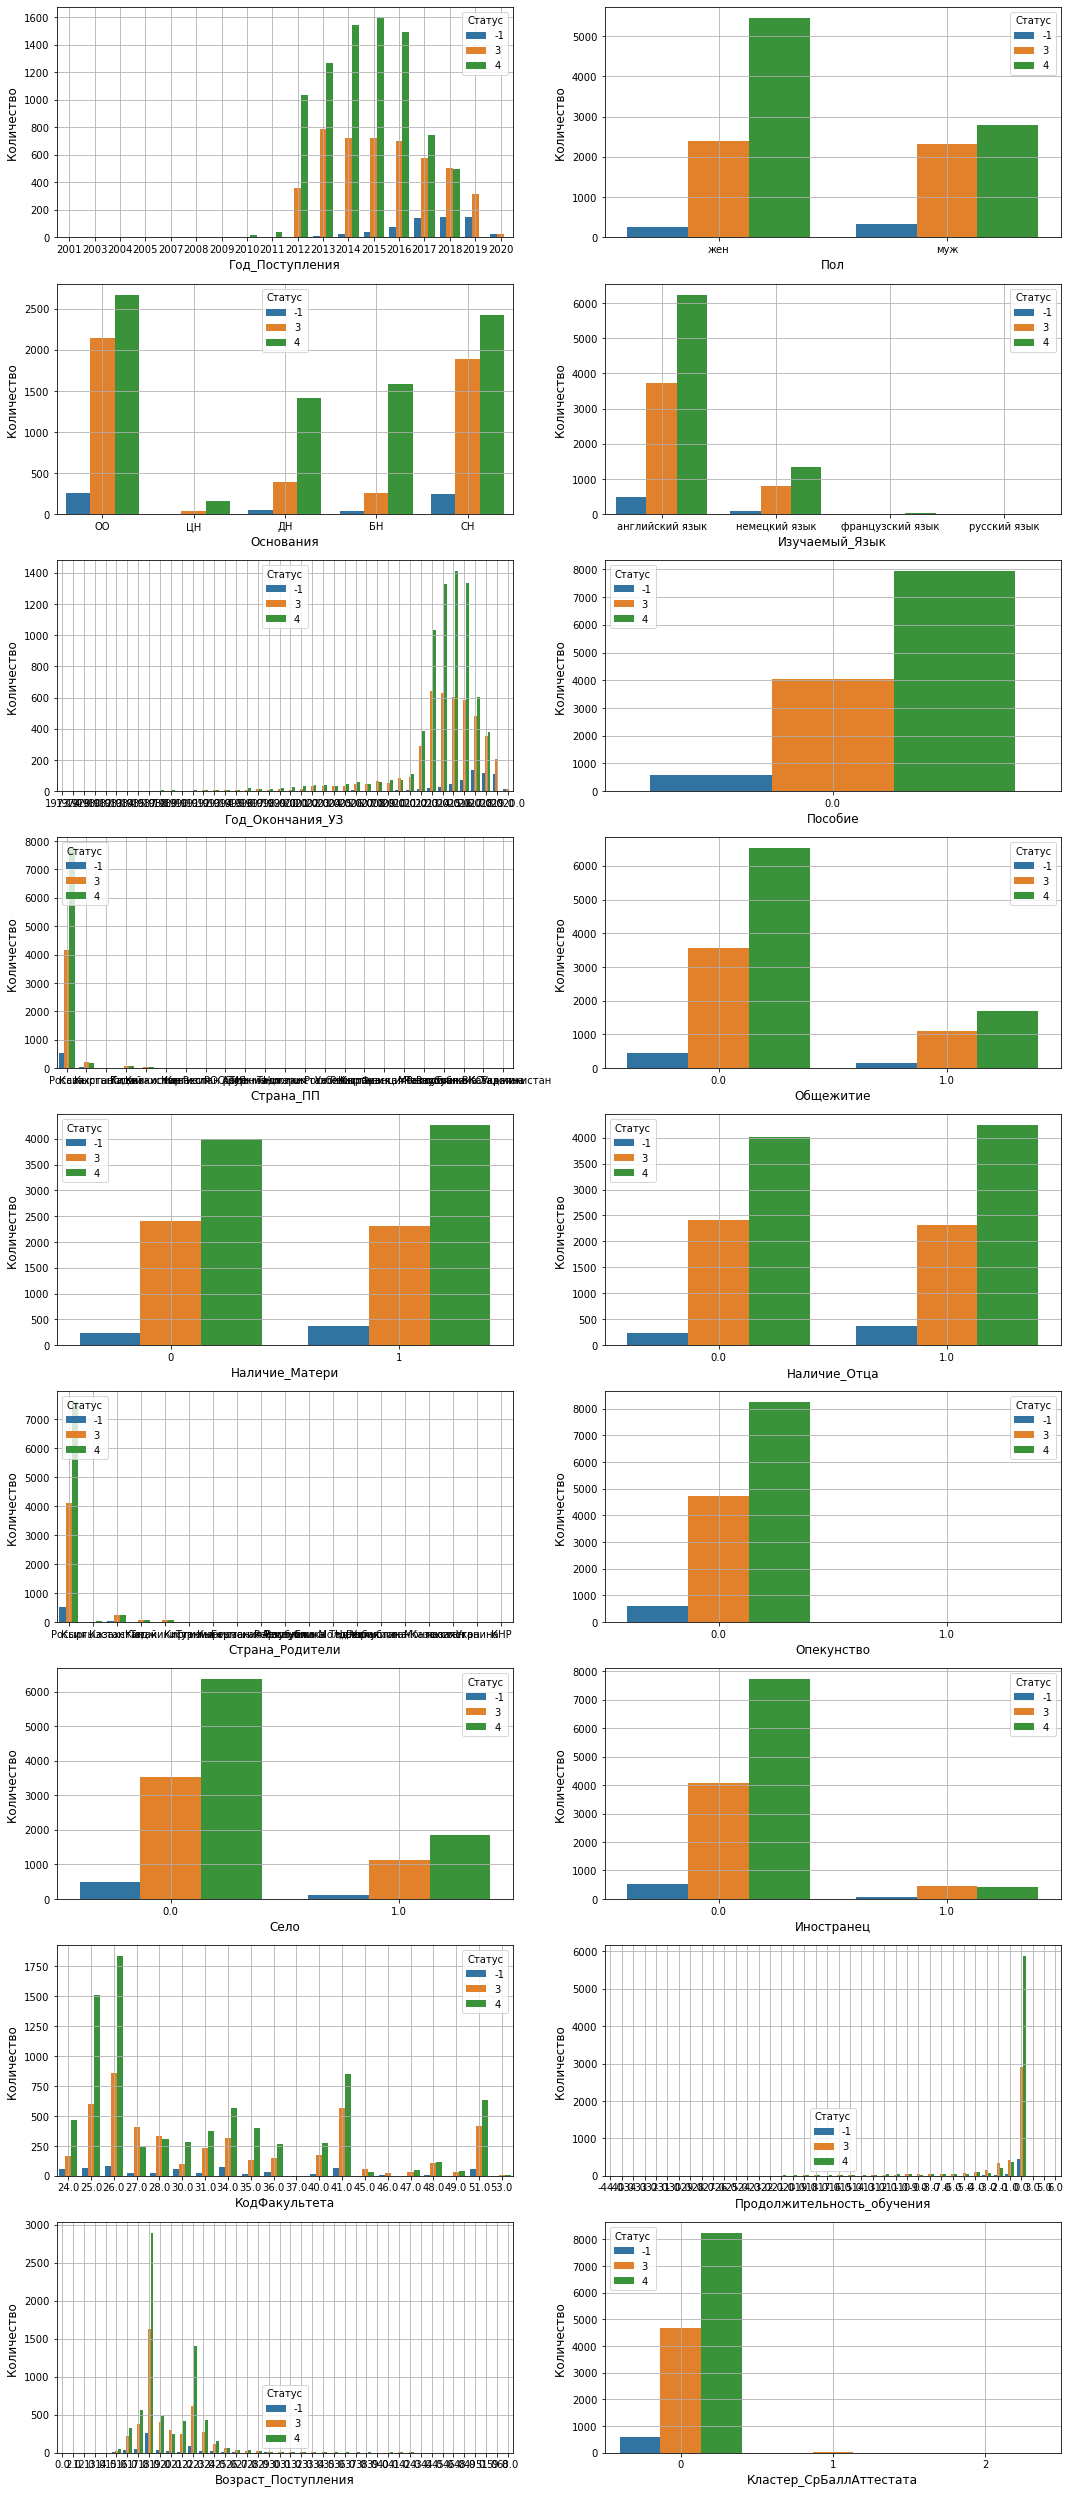

In [88]:
func_plot(train.columns.drop(['Дата_Рождения', 'Статус', 'Где_Находится_УЗ', 'Уч_Заведение', 'Регион_ПП', 
                              'Город_ПП', 'Дата_Рождения_Год', 'Дата_Рождения_Месяц', 'Дата_Рождения_День',
                            'ID', 'Код_группы', 'СрБаллАттестата']))

Выделим целевой признак

In [89]:
features = train.drop(columns=['Статус',
                               'Страна_Родители',
                               'Год_Окончания_УЗ',
                              ])

target = train['Статус']

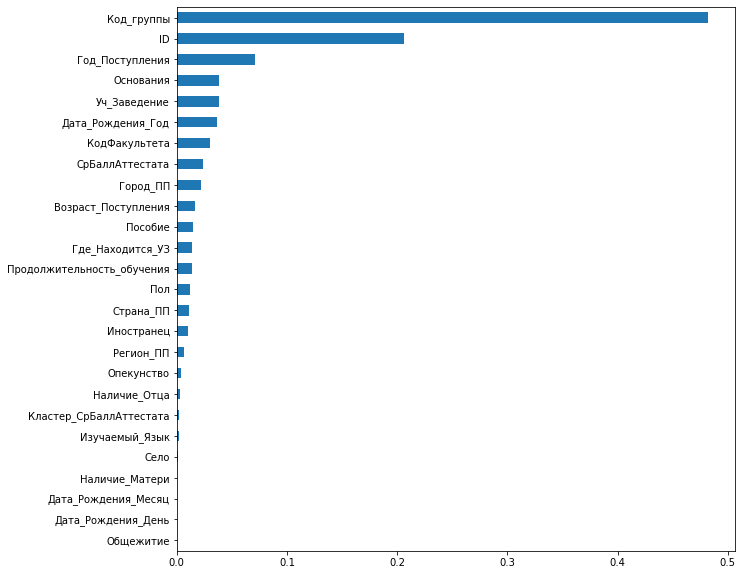

In [90]:
features_enc = features.drop(columns=['Дата_Рождения'])
columns_for_encoder = features_enc.select_dtypes(include='object').columns.tolist()
features_enc[columns_for_encoder] = features_enc[columns_for_encoder].fillna('неизвестно')

encoder_ordinal = OrdinalEncoder()
features_enc[columns_for_encoder] = encoder_ordinal.fit_transform(features_enc[columns_for_encoder]).astype('int')

features_enc = features_enc.fillna(-1)

importances = mutual_info_classif(features_enc, target, random_state=RANDOM_SEED)

feature_importances = pd.Series(importances, features_enc.columns[0:len(features_enc.columns)])
feature_importances = feature_importances.sort_values()

plt.figure(figsize=(10,10))
feature_importances.plot(kind='barh')
plt.show()

Заполним пропуски в категориальных столбцах "неизветно"

In [91]:
columns_for_encoder = features.select_dtypes(include='object').columns.tolist()

In [92]:
features[columns_for_encoder] = features[columns_for_encoder].fillna('неизвестно')

Обучим модель CatBoostClassifier

In [93]:
model =  CatBoostClassifier(random_state=RANDOM_SEED,
                            auto_class_weights='Balanced', 
                            loss_function='MultiClass', 
                            cat_features = columns_for_encoder,
                            silent=True)

model.fit(features, target)
abs(cross_val_score(model, 
                    features,
                    target, 
                    cv=5, 
                    scoring='f1_weighted').mean())

0.8685583681161558

Важность признаков модели CatBoostClassifier

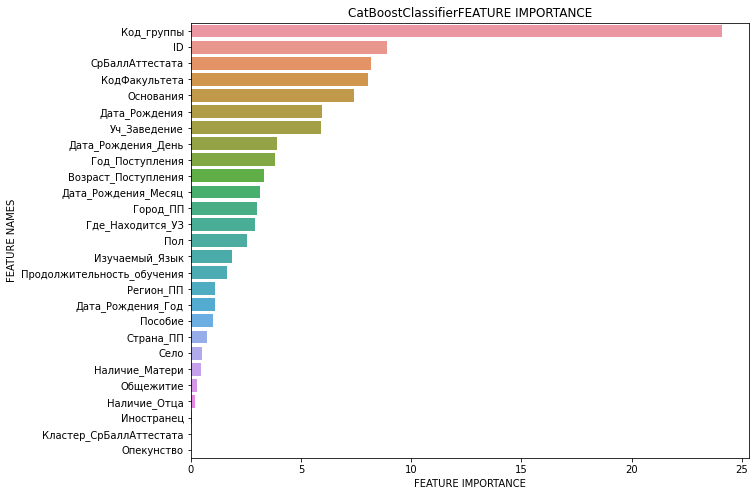

In [94]:
plot_feature_importance(model.get_feature_importance(), features.columns, 'CatBoostClassifier')

Тестирование модели

In [97]:
features_test = test.drop(columns=['Страна_Родители',
                                   'Год_Окончания_УЗ',
                                  ])

In [98]:
features_test[columns_for_encoder] = features_test[columns_for_encoder].fillna('неизвестно')

In [99]:
pred = model.predict(features_test)

Запись результата

In [100]:
test["Статус"] = pred

In [101]:
df_submission = test[['ID', 'Статус']]

In [102]:
df_submission.to_csv("submission_final.csv", index=False)